<a href="https://colab.research.google.com/github/fajardgb/n-bitflipflop-ameretat/blob/main/Copy_of_Group_2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>


In [ ]:
##steps for notebook
# import repos and install packages
# create 3BFF env
# train GRU and NODE
# fit affine transformation btwn them
# find fixed points btwn them
# train 2 more models  (RNN, LSTM) --> maybe just the LSTM?
# compare their activity using DSA -- 6 comparisons
# create a 4BFF and repeat the DSA analysis
# compare complexities of the 2 tasks (??)

###in the chart, they suggest DSA on the 1st two (GRU vs NODE) and then DSA on 4BFF with GRU vs LSTM

In [ ]:
print("Hello")

Hello


In [2]:
! git clone https://github.com/fajardgb/random-target-ameretat.git

fatal: destination path 'random-target-ameretat' already exists and is not an empty directory.


In [3]:
! git clone https://github.com/fajardgb/n-bitflipflop-ameretat

Cloning into 'n-bitflipflop-ameretat'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 6), reused 14 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 7.51 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
#get ctd repo

! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark #ctd/task_modeling/model/rnn.py - path for model architecture creation
%cd ComputationThruDynamicsBenchmark
! pip install -e .

# RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN


Cloning into 'ComputationThruDynamicsBenchmark'...
remote: Enumerating objects: 3359, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3359 (delta 519), reused 501 (delta 501), pack-reused 2774 (from 1)
Receiving objects: 100% (3359/3359), 296.08 MiB | 23.34 MiB/s, done.
Resolving deltas: 100% (1883/1883), done.
Updating files: 100% (262/262), done.
/content/ComputationThruDynamicsBenchmark
Obtaining file:///content/ComputationThruDynamicsBenchmark
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5

In [1]:
!pip uninstall -y torchaudio torchvision

Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124


In [56]:
## GET BACK TO THE DIRECTORY AND CONFIGURE .env

%cd /content/ComputationThruDynamicsBenchmark/
envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
EVAL_TARGET_FILE=eval_target.h5
"""

with open('.env','w') as f:
  f.write(envStr)



/content/ComputationThruDynamicsBenchmark


In [2]:
#get DSA repo

!git clone https://github.com/mitchellostrow/DSA
%cd DSA/
!pip install -e .

/content/ComputationThruDynamicsBenchmark
Cloning into 'DSA'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 393 (delta 52), reused 49 (delta 25), pack-reused 304 (from 1)
Receiving objects: 100% (393/393), 1.53 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (225/225), done.
/content/ComputationThruDynamicsBenchmark/DSA
Obtaining file:///content/ComputationThruDynamicsBenchmark/DSA
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 8.1 MB/s eta 0:00:00
  Running setup.py develop for DSA


In [29]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
#HOME_DIR = os.getenv('HOME_DIR')
HOME_DIR = '/content'
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

/content


# **Create 3BFF task environment**

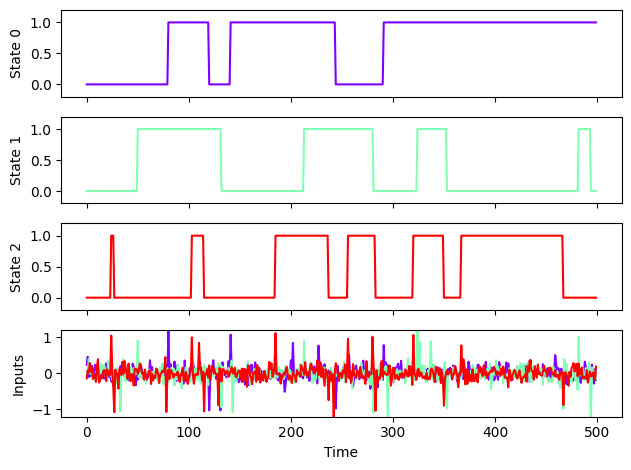

In [4]:
# create 3BFF task env

from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3 # The number of bits in the flip-flop (default: 3)
trial_length = 500 # The number of time steps in each trial (default: 500)
switch_prob = 0.015 # The probability of an input pulse (default: 0.015 pulses/channel / time step)
noise = 0.15 # The standard deviation of the Gaussian noise added to the input (default: 0.15)

# This line creates the NBitFlipFlop environment
env_3bff = NBitFlipFlop(
    n = n,
    n_timesteps=trial_length,
    switch_prob=switch_prob,
    noise=noise
    )

# Renders a random trial from the environment
env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.


**Try changing the parameters of your 3BFF environment to see how the behavior changes!**

Another way to visualize this is to view the three states in 3D. Below, you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as a column.

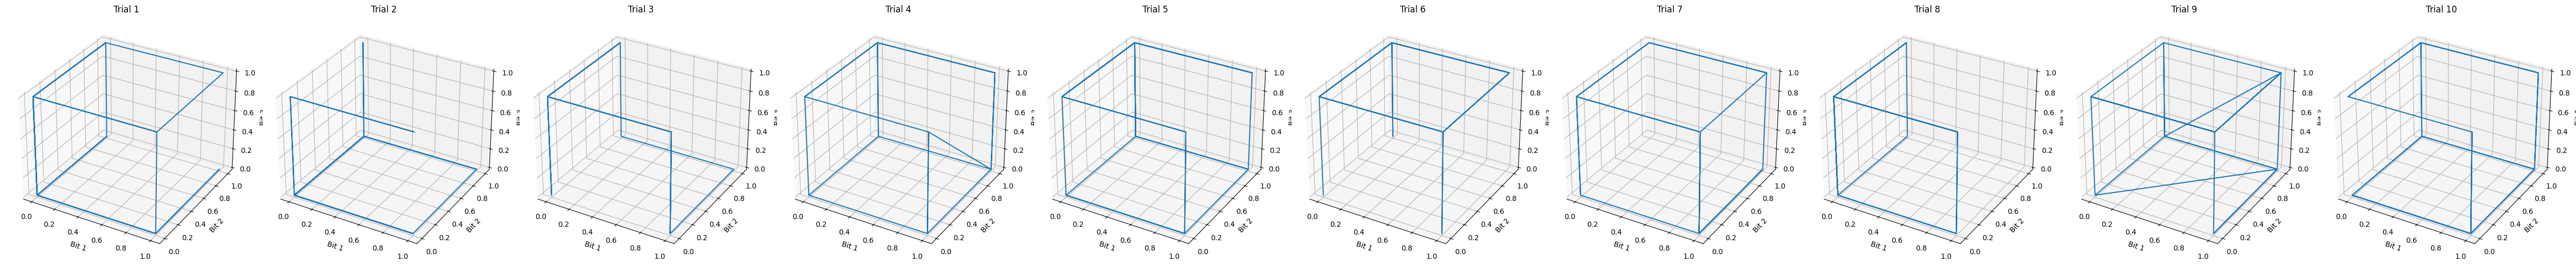

In [5]:
env_3bff.render_3d(n_trials=10)

# **Import the trained models**

In [37]:
import pickle
import os

os.environ['HOME_DIR'] = '/content'
#get GRU model for 3bff
gru_path = pathlib.Path(HOME_DIR) / 'n-bitflipflop-ameretat' / 'models' / 'models_GRU_128' / ""

# import datamodule
rnn_data_module = pickle.load(open(gru_path / 'datamodule_sim.pkl', 'rb'))

rnn_model = pickle.load(open(gru_path / 'model.pkl', 'rb'))

print(gru_path)

/content/n-bitflipflop-ameretat/models/models_GRU_128


In [38]:
#import the saved NODE model for 3bff

node_path = pathlib.Path(HOME_DIR) / 'n-bitflipflop-ameretat' / 'models' / 'models_NODE_3' / ""

# import datamodule
node_data_module = pickle.load(open(node_path / 'datamodule_sim.pkl', 'rb'))

node_model = pickle.load(open(node_path / 'model.pkl', 'rb'))

# **Inspect latent activity between the 2 models**

In [43]:
from ctd.comparison.analysis.tt.tt import Analysis_TT
import ctd.task_modeling.datamodule.task_datamodule as task_dm
#this is a temporary patch to fix a path issue

task_dm.HOME_DIR = '/content'

filepath_with_slash = str(gru_path) + '/'

# Then try creating your analysis object
analysis_GRU_128 = Analysis_TT(
    run_name = "GRU_128_3bff",
    filepath = filepath_with_slash)

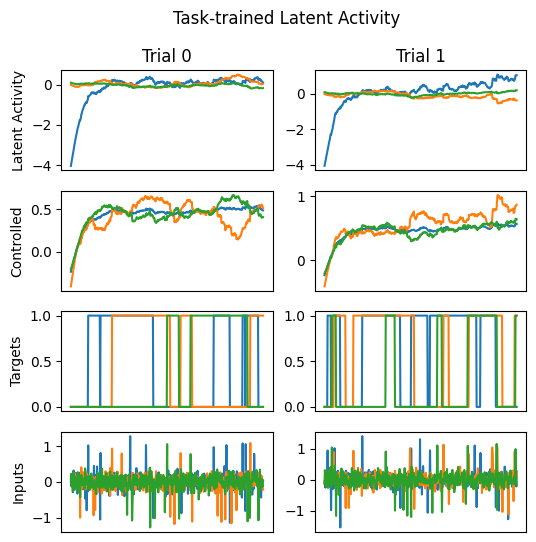

In [44]:
# same as above but for NODE

nodepath_with_slash = str(node_path) + '/'

analysis_NODE = Analysis_TT(
    run_name = "NODE_3_3bff",
    filepath = nodepath_with_slash)

analysis_NODE.plot_trial_io(num_trials = 2)

Importantly, the analysis object also provides functions that give access to the raw latent activity, predicted outputs, etc. of the trained models! All of these functions accept a "phase" variable that designates whether to return the training and/or validation datasets.
These functions are:
- `get_latents()`: Returns latent activity of the trained model
- `get_inputs()`: Returns the inputs to the model (for 3BFF, the input pulses)
- `get_model_output()`: Returns a dict that contains all model outputs:
  - controlled - the variable that the model is controlling
  - latents - the latent activity
  - actions - the output from the model (for RandomTarget only)
  - states - the state of the environment (for RandomTarget only)
  - joints - Joint angles (for RandomTarget only)

In [45]:
print(f"All data shape: {analysis_GRU_128.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128.get_latents(phase = 'val').shape}")

All data shape: torch.Size([1000, 500, 128])
Train data shape: torch.Size([800, 500, 128])
Validation data shape: torch.Size([200, 500, 128])


# **Use affine transformations to compare latent activity**

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:

latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

Latent shape for source model: (800, 500, 128)
Latent shape for target model: (800, 500, 3)


In [47]:
# Perform PCA on both latent spaces to find axes of highest variance

pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))


In [48]:
# Fit a linear regression model to predict the target latents from the source latents

reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [0.6553271  0.36797577 0.17243773]
Variance-weighted R2 of linear regression fit: 0.6375251412391663


***Explain what is happening;  interpret the above results***



So, the variance weighted R2 from the source to the target is ~0.93.

*Try reversing the direction (the source as NODE and target as GRU) and see how well the model fits*


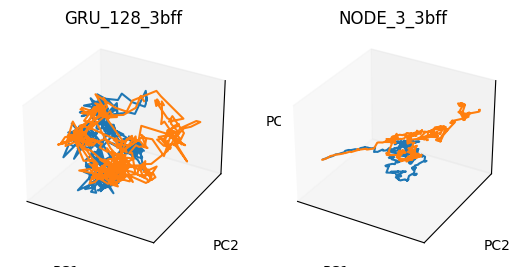

In [49]:
from ctd.comparison.comparison import Comparison

# compare latent activity via affine transformation
# this should produce a plot

comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

# **Find fixed points between the GRU and NODE**

Use fixed-point finding to inspect the linearized dynamics of the trained model.

Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

In [ ]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(3),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=20000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-5,
    )

***Explain what we are seeing above; how to interpret
What is the Q value?  What does it tell us?
Whta do the fixed points tell you about the computation for 3BFF?

In [ ]:
with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps = analysis_NODE.plot_fps(
        inputs= torch.zeros(3),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=20000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-5,
    )

# **Train an LSTM network**

In [ ]:
# Train another model(s) -- start w LSTM, then maybe basic RNN or something else


#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
# may not be able to just import this from nn.module since it needs to approximate the GRU_Cell
# look in rnn.py to read the requirements


In [ ]:
# and visualize the latent dynamics

# **DSA: GRU vs NODE**

In [ ]:
## Do DSA on the GRU vs NODE
from DSA import DSA


# I'm not sure if this will work
dsa = DSA(X=latents_source_val, Y=latents_targ_val, n_delays=1)

# Call the fit method and save the result
similarities = dsa.fit_score()

print(f"DSA similarity between GRU and NODE: {similarities:.4f}")

# **DSA: GRU vs LSTM**

In [ ]:
# Do DSA on the GRU vs LSTM

In [ ]:
# explain how they are simliar, interpret the results

# **4BFF task**

In [ ]:
# Create a 4BFF task and repeat!

In [ ]:
env_4bff = NBitFlipFlop(
    n = 4,
    n_timesteps=trial_length,
    switch_prob=switch_prob,
    noise=noise
    )

# Renders a random trial from the environment
env_4bff.render()

In [ ]:
# add code to visualize the hypercube

In [ ]:
# train GRU, NODE, and LSTM on 4BFF and save models
# here we should once again import the saved models

In [ ]:
# rerun: affine? fixed point? DSA?

talk about the simliarities/differences between 3 bit and 4


In [ ]:
# compare the complexities of the task?  Not sure how to do that exactly

# **Conclusion**

discussion
